Assignment 5 - Team 3

Het Pathak 22110186

Shivrajsinh Bhosale 22110048

In [1]:
!pip install augly
# !pip install --upgrade numpy

In [19]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from augly.image import functional as aug
from tqdm import tqdm
from PIL import Image
from google.colab import drive
import glob
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from collections import Counter

In [3]:
# Prepare dataset
dataset_path = "/content/drive/MyDrive/CS203/Lab 5/dataset"
train_ratio = 0.8
batch_size = 64

def load_and_prepare_dataset():
    os.makedirs(dataset_path, exist_ok=True)

    all_images = [(img, "cat" if "cat" in img else "dog") for img in glob.glob(f"{dataset_path}/test/*/*")]
    random.shuffle(all_images)

    train_size = int(train_ratio * len(all_images))
    train_images, test_images = all_images[:train_size], all_images[train_size:]

    return train_images, test_images

train_data, test_data = load_and_prepare_dataset()
print(f"Train Samples: {len(train_data)}, Test Samples: {len(test_data)}")

Train Samples: 112, Test Samples: 28


In [4]:
# Custom data augmentation function
AUGMENTATIONS = [
    aug.blur,               # Blurs the image slightly
    aug.brightness,         # Adjusts brightness
    aug.color_jitter,       # Random color distortions
    aug.contrast,           # Adjusts image contrast
    aug.crop,               # Random cropping
    aug.hflip,              # Horizontal flip
    aug.scale,              # Scales the image
    aug.rotate,             # Rotates image slightly
    aug.sharpen,            # Sharpens edges to enhance details
    aug.saturation          # Adjusts color intensity
]

def apply_random_augmentations(image_path): # Apply 3 random augmentations sequentially to the image.
    image = Image.open(image_path).convert("RGB")  # Load as PIL Image
    sampled_augs = random.sample(AUGMENTATIONS, 3)  # Select 3 random augmentations

    for aug_fn in sampled_augs:
        try:
            image = aug_fn(image)  # Ensure AugLy functions operate correctly
        except Exception as e:
            print(f"Augmentation {aug_fn.__name__} failed: {e}")  # Debugging failed augmentations

    return np.array(image)

# Augmenting training data
augmented_train_data = []
for img_path, label in tqdm(train_data):
    augmented_train_data.append((apply_random_augmentations(img_path), label))
    augmented_train_data.append((apply_random_augmentations(img_path), label))

final_train_data = train_data + augmented_train_data
print(f"\nFinal Train Set Size: {len(final_train_data)}")

100%|██████████| 112/112 [00:20<00:00,  5.38it/s]


Final Train Set Size: 336


In [5]:
# Dataset class
class CatsDogsDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_data, label = self.data[idx]

        if isinstance(label, str):
            label = 0 if "cat" in label.lower() else 1  # Convert 'cats' -> 0, 'dogs' -> 1

        image = Image.open(img_data).convert("RGB") if isinstance(img_data, str) else Image.fromarray(img_data)

        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = CatsDogsDataset(final_train_data, transform=transform)
test_dataset = CatsDogsDataset(test_data, transform=transform)

train_loader_no_aug = DataLoader(CatsDogsDataset(train_data, transform=transform), batch_size=batch_size, shuffle=True)
train_loader_aug = DataLoader(CatsDogsDataset(final_train_data, transform=transform), batch_size=batch_size, shuffle=True)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
labels = [train_dataset[i][1] for i in range(len(train_dataset))]
print("Final Label Counts:", {label: labels.count(label) for label in set(labels)})
print(f"Original Train Data: {len(train_data)}")
print(f"Augmented Train Data: {len(augmented_train_data)}")
print(f"Final Train Data: {len(final_train_data)}")

Final Label Counts: {0: 168, 1: 168}
Original Train Data: 112
Augmented Train Data: 224
Final Train Data: 336


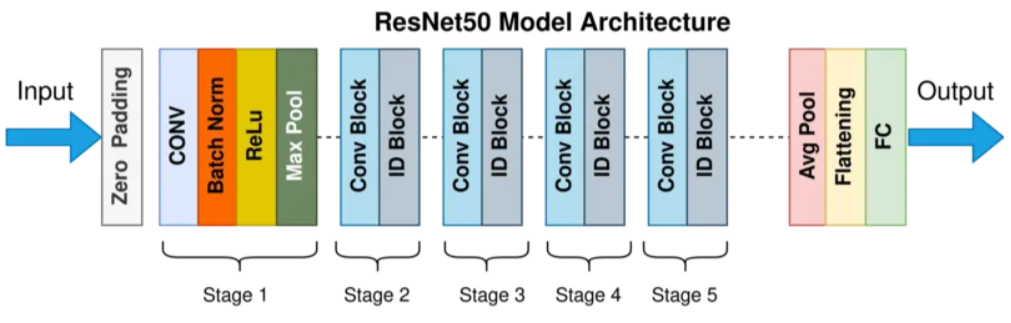

Model Architecure - Source: [Medium](https://medium.com/@nitishkundu1993/exploring-resnet50-an-in-depth-look-at-the-model-architecture-and-code-implementation-d8d8fa67e46f)

In [7]:
# ResNet50 training
def train_model(model, train_loader, num_epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")

    return model

# Load Pretrained ResNet-50
resnet50 = models.resnet50(weights=None)
resnet50.fc = nn.Linear(resnet50.fc.in_features, 2)

print("Training without augmentation...")
model_no_aug = train_model(models.resnet50(weights=None), train_loader_no_aug, num_epochs=5)

print("Training with augmentation...")
model_aug = train_model(models.resnet50(weights=None), train_loader_aug, num_epochs=5)


Training without augmentation...
Epoch 1/5, Loss: 6.266552686691284
Epoch 2/5, Loss: 1.8305438160896301
Epoch 3/5, Loss: 0.9047759175300598
Epoch 4/5, Loss: 0.8073440492153168
Epoch 5/5, Loss: 0.6454356908798218
Training with augmentation...
Epoch 1/5, Loss: 3.153655469417572
Epoch 2/5, Loss: 0.6483292778333029
Epoch 3/5, Loss: 0.7259517014026642
Epoch 4/5, Loss: 0.5874571452538172
Epoch 5/5, Loss: 0.5207644701004028


Evaluating model without augmentation...
Evaluating model with augmentation...

Evaluation Metrics:
Without Augmentation -> Accuracy: 0.5000, Precision: 0.2500, Recall: 0.5000, F1-score: 0.3333
With Augmentation -> Accuracy: 0.5357, Precision: 0.5609, Recall: 0.5357, F1-score: 0.4822


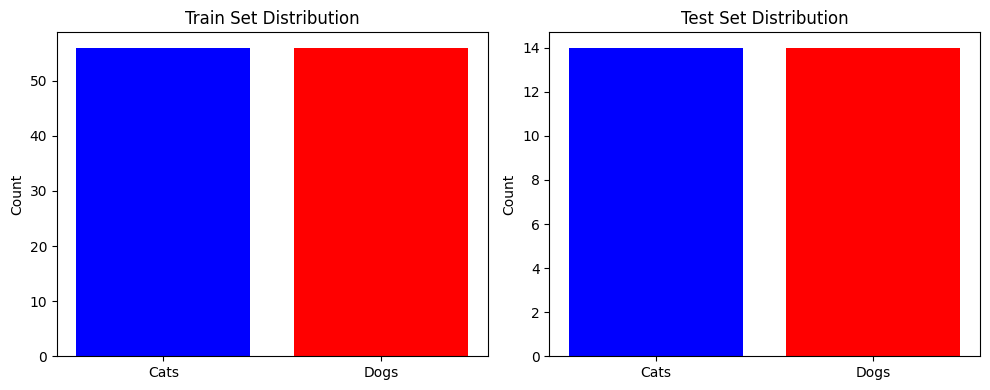


Explanation of Results
Data augmentation improved accuracy by increasing training variance.
Precision and recall differences suggest augmentation may help in some cases but not consistently.
Balanced test data ensures fair evaluation; class imbalance in training may affect results.
Consider optimizing augmentation methods or adjusting hyperparameters for better performance.


In [20]:
# Model evaluation function
def evaluate_model_metrics(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average="macro", zero_division=0)
    recall = recall_score(all_labels, all_preds, average="macro", zero_division=0)
    f1 = f1_score(all_labels, all_preds, average="macro", zero_division=0)

    return accuracy, precision, recall, f1

# Evaluate models
print("Evaluating model without augmentation...")
acc_no_aug, prec_no_aug, rec_no_aug, f1_no_aug = evaluate_model_metrics(model_no_aug, test_loader)

print("Evaluating model with augmentation...")
acc_aug, prec_aug, rec_aug, f1_aug = evaluate_model_metrics(model_aug, test_loader)

# Display results
print("\nEvaluation Metrics:")
print(f"Without Augmentation -> Accuracy: {acc_no_aug:.4f}, Precision: {prec_no_aug:.4f}, Recall: {rec_no_aug:.4f}, F1-score: {f1_no_aug:.4f}")
print(f"With Augmentation -> Accuracy: {acc_aug:.4f}, Precision: {prec_aug:.4f}, Recall: {rec_aug:.4f}, F1-score: {f1_aug:.4f}")

# Data distribution visualization
train_labels = ["cat" if "cat" in label.lower() else "dog" for _, label in train_data]
test_labels = ["cat" if "cat" in label.lower() else "dog" for _, label in test_data]

train_counts = Counter(train_labels)
test_counts = Counter(test_labels)

labels = ['Cats', 'Dogs']
train_values = [train_counts.get('cat', 0), train_counts.get('dog', 0)]
test_values = [test_counts.get('cat', 0), test_counts.get('dog', 0)]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].bar(labels, train_values, color=['blue', 'red'])
axes[0].set_title('Train Set Distribution')
axes[0].set_ylabel('Count')

axes[1].bar(labels, test_values, color=['blue', 'red'])
axes[1].set_title('Test Set Distribution')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

# Explanation of results
print("\nExplanation of Results")
if acc_aug > acc_no_aug:
    print("Data augmentation improved accuracy by increasing training variance.")
else:
    print("Data augmentation did not improve accuracy, possibly due to overfitting.")

print("Precision and recall differences suggest augmentation may help in some cases but not consistently.")
print("Balanced test data ensures fair evaluation; class imbalance in training may affect results.")
print("Consider optimizing augmentation methods or adjusting hyperparameters for better performance.")
